<a href="https://colab.research.google.com/github/DeepaliVerma/personal_files/blob/main/Scene_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://places.csail.mit.edu/demo/12.jpg

--2021-09-07 07:19:31--  http://places.csail.mit.edu/demo/12.jpg
Resolving places.csail.mit.edu (places.csail.mit.edu)... 128.30.195.26
Connecting to places.csail.mit.edu (places.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63736 (62K) [image/jpeg]
Saving to: ‘12.jpg’

12.jpg              100%[===================>]  62.24K  --.-KB/s    in 0.05s   

2021-09-07 07:19:32 (1.23 MB/s) - ‘12.jpg’ saved [63736/63736]



In [9]:
from google.colab.patches import cv2_imshow
import cv2

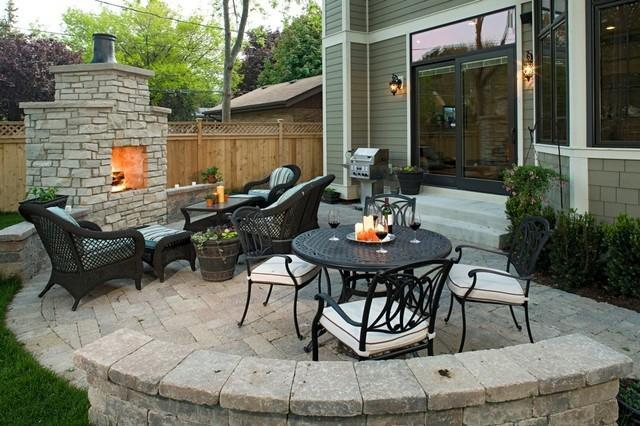

resnet18 prediction on 12.jpg
0.621 -> patio
0.296 -> restaurant_patio
0.021 -> porch
0.018 -> beer_garden
0.012 -> courtyard


In [11]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

# th architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

# load the test image
img_name = '12.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))
img = cv2.imread('12.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))